In [1]:
# !pip install datasets

In [2]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json

from datasets import load_dataset

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from src.helpers import preprocessing as preproc
from src.helpers.postprocessing import from_list_to_string, safe_json_load
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.openai_api import chat_completion as openai_chat_completion
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from src.google_ai_api import chat_completion as google_chat_completion

In [3]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.path.join(os.getenv("OUTPUTS_PATH"), "robustness_checks", "rb3")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

# Getting data

In [4]:
dataset = load_dataset("amazon_polarity")
FILES_PREFIX = "amazon_reviews_rb3"

In [5]:
X_train = [f"{title} {text}" for title, text in zip(dataset['train']['title'], dataset['train']['content'])]
X_test = [f"{title} {text}" for title, text in zip(dataset['test']['title'], dataset['test']['content'])]

y_train = dataset['train']['label']
y_test = dataset['test']['label']

data = pd.DataFrame({ 'text': X_train, 'label': y_train })

In [6]:
N_SAMPLE = 5000

df_A = data[data['label'] == 1].sample(N_SAMPLE, random_state=RANDOM_STATE)
df_B = data[data['label'] == 0].sample(N_SAMPLE, random_state=RANDOM_STATE)
df = pd.concat([df_A, df_B], axis=0).reset_index(drop=True)

In [7]:
# Change that concerns the robustness check: randomly shuffling the column "label"
df['label'] = df['label'].sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [8]:
df

,text,label
0,Perfect Mantra I've been looking for this mant...,0
1,Quality I'm just a little disapointed with the...,1
2,Exceptional murder-mystery writer scores big. ...,1
3,all the prodding questions you never wanted to...,1
4,Best Wok ever I am so glad I bought this wok. ...,1
...,...,...
9995,Doesn't work for me While I applaud the focus ...,0
9996,Beyond Stupid One wonders about all the people...,0
9997,Buyer Be Very Wary The trusted leader in child...,0
9998,I'll bring earplugs to the state fair next yea...,1


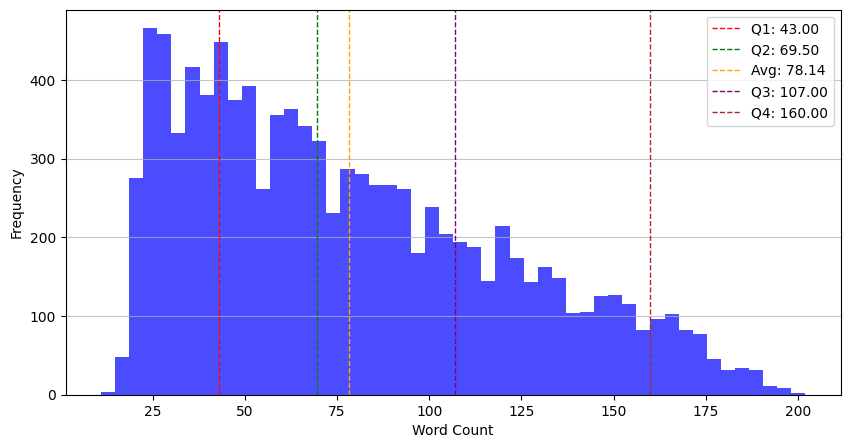

In [9]:
word_counts = df["text"].apply(lambda x: len(x.split()))
q1_word_counts = word_counts.quantile(0.25)
q2_word_counts = word_counts.quantile(0.50)
avg_word_counts = word_counts.mean()
q3_word_counts = word_counts.quantile(0.75)
q4_word_counts = word_counts.quantile(0.95)
plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=50, color='blue', alpha=0.7)
plt.axvline(q1_word_counts, color='red', linestyle='dashed', linewidth=1, label=f'Q1: {q1_word_counts:.2f}')
plt.axvline(q2_word_counts, color='green', linestyle='dashed', linewidth=1, label=f'Q2: {q2_word_counts:.2f}')
plt.axvline(avg_word_counts, color='orange', linestyle='dashed', linewidth=1, label=f'Avg: {avg_word_counts:.2f}')
plt.axvline(q3_word_counts, color='purple', linestyle='dashed', linewidth=1, label=f'Q3: {q3_word_counts:.2f}')
plt.axvline(q4_word_counts, color='brown', linestyle='dashed', linewidth=1, label=f'Q4: {q4_word_counts:.2f}')
plt.legend()
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Pre-processing data

##### 1. Data cleaning

In [10]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Loading cleaned texts from /Users/tig1/Programming/TOPOL/data/amazon_reviews_rb3_texts.pickle
Loaded 10000 texts


##### 2. Embedding texts

In [11]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["text"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Loading embeddings from /Users/tig1/Programming/TOPOL/data/amazon_reviews_rb3_embeddings.pickle
Loaded 10000 embeddings


##### 3.a. Sentiment Analysis: FinBERT

In [12]:
sentiment_model = SentimentModel(model_name="ProsusAI/finbert", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_finbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_finbert"] = sentiments
df["sentiment_score_finbert"] = df["sentiment_finbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/amazon_reviews_rb3_sentiments_finbert.pickle
Loaded 10000 sentiments


##### 3.b. Sentiment Analysis: Multilingual DistilBERT

In [13]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_distilbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_distilbert"] = sentiments
df["sentiment_score_distilbert"] = df["sentiment_distilbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/amazon_reviews_rb3_sentiments_distilbert.pickle
Loaded 10000 sentiments


# TOPOL Modeling

### Prepare data

In [14]:
data_A = df[df["label"] == 1].copy()
data_B = df[df["label"] == 0].copy()

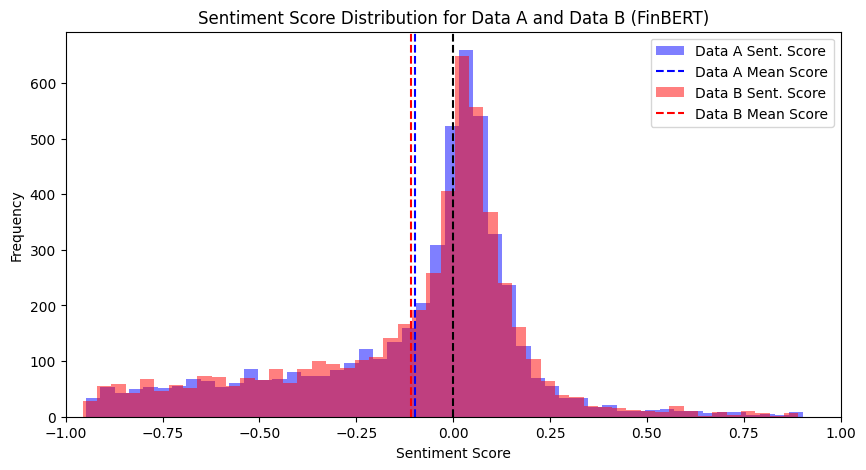

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score_finbert"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score_finbert"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Data A and Data B (FinBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_finbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

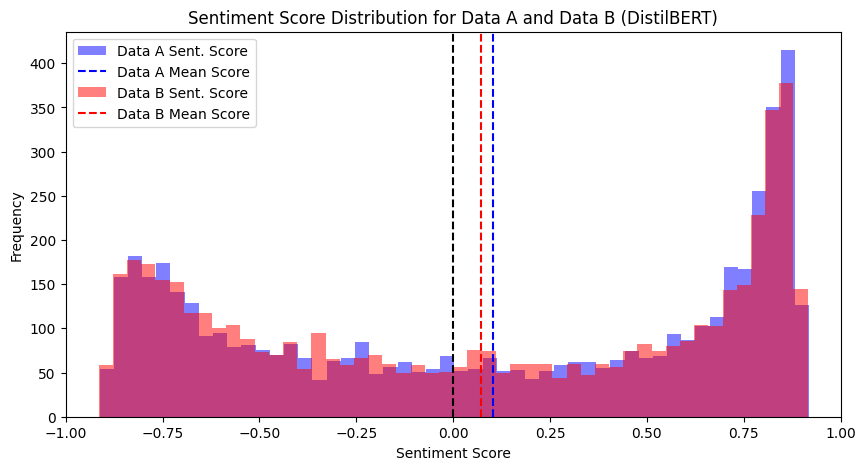

In [16]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score_distilbert"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score_distilbert"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Data A and Data B (DistilBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_distilbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Prepare UMAP, Leiden and vectorizer model

In [17]:
umap_params = {
    'n_neighbors': 100,
    'min_dist': 0.0,
    'metric': 'cosine',
    'random_state': RANDOM_STATE
}

leiden_params = {
    'resolution': 1.5,
    'modularity': 'dugue',
    'random_state': RANDOM_STATE,
}

vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, 2), max_features=10000)

topol_model = TOPOL(
    n_components=50,
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    vectorizer_model=vectorizer_model,
    supervised=True,
)

### TOPOL modeling analysis

In [18]:
topol_model.apply_modeling(
    df_A=data_A,
    df_B=data_B,
    n_top_freq_words=20,
    n_repr_docs=10,
    n_top_tf_idf_words=20
)

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP applied successfully.
Leiden clustering applied successfully.


/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['date', 'location', 'num', 'organization', 'time'] not in stop_words.
  warnings.warn(


Cluster information extracted successfully.


In [19]:
topol_model.dataset_A.cluster_info

,Cluster,Count,Top_Words,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,684,"{'album': 484, 'cd': 454, 'num': 362, 'date': ...","[0.00847179536186979, -0.0047974522974088855, ...","[-1.589695847348163, 10.117886145212497]",[Like finding buried treasure... Like any trea...,"{'num': 0.33438376143099346, 'cd': 0.217349444..."
1,1,678,"{'movie': 757, 'film': 302, 'date': 290, 'num'...","[-0.004280716201609772, 0.03318373694579768, -...","[-2.0597421424930427, 6.74036007469031]",[They call this entertainment I am sure am gla...,"{'movie': 0.4689954077877773, 'date': 0.196675..."
2,2,553,"{'num': 435, 'date': 365, 'time': 214, 'produc...","[-0.014064847572421022, 0.003700358415454103, ...","[4.595841941091941, 7.642853676087171]","[Do yourself a favor, don't consider this junk...","{'date': 0.2963314265830401, 'product': 0.2266..."
3,3,475,"{'book': 764, 'read': 292, 'just': 203, 'like'...","[0.002074859704612448, 0.040657275406564095, -...","[-4.0873069389242875, 3.069402242459749]",[Very Disappointing I'm not sure where to star...,"{'book': 0.4227301295955581, 'read': 0.2029104..."
4,4,474,"{'date': 251, 'num': 242, 'great': 135, 'just'...","[0.006374801512160017, 0.011020816641854168, -...","[3.661745352332602, 5.9216551961778086]",[Two Thumbs Down Just bought this toy TIME for...,"{'date': 0.21729846767910702, 'daughter': 0.17..."
5,5,475,"{'book': 655, 'read': 346, 'date': 190, 'story...","[0.010711523250295278, 0.022272005150313672, -...","[-3.37595730630975, 3.9385364025517515]",[Pleasant Read! What a breath of fresh air thi...,"{'book': 0.5092452156918934, 'read': 0.2909972..."
6,6,408,"{'num': 247, 'date': 171, 'use': 158, 'great':...","[-0.009826092388819091, 0.011571048041742853, ...","[4.919334441715596, 6.207294370029487]",[Broke after one use! I bought this waffle mak...,"{'date': 0.20833410152455228, 'time': 0.187500..."
7,7,394,"{'book': 758, 'num': 171, 'good': 134, 'date':...","[-0.005287827046125356, 0.020700117138505152, ...","[-2.1207659745276883, 2.606475048863948]","[Dummies, Unite! Boycott! A frustrating book d...","{'book': 0.5315489258921446, 'num': 0.23033786..."
8,8,228,"{'book': 374, 'read': 122, 'date': 79, 'great'...","[-0.0018691304696978094, 0.023195775750903983,...","[-2.780160078876897, 3.139676437043307]","[Unexpected Elegant in it's simplicity, profou...","{'book': 0.4062566114137608, 'read': 0.2472866..."
9,9,174,"{'num': 211, 'date': 63, 'amazon': 63, 'produc...","[-0.005061470804101755, 0.004043781244391361, ...","[2.2169681583670364, 6.408108981176355]",[Review for CSI NUM-NUM I received this produc...,"{'num': 0.5845321808173938, 'amazon': 0.257881..."


In [20]:
topol_model.dataset_B.cluster_info

,Cluster,Count,Top_Words,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,720,"{'cd': 481, 'album': 471, 'music': 333, 'num':...","[0.008685350088907424, -0.0024931736814557503,...","[-1.5823766420284906, 10.007277592023213]",[NUM well crafted songs does NOT make a great ...,"{'cd': 0.321321971476643, 'good': 0.3044102887..."
1,1,682,"{'movie': 758, 'num': 291, 'date': 273, 'film'...","[-0.0038658663457612195, 0.034795201570401585,...","[-2.0698344446172463, 6.789538840394566]",[Don't be a stooge This is a classic example o...,"{'movie': 0.40510443318506456, 'book': 0.19803..."
2,2,550,"{'num': 447, 'date': 365, 'product': 220, 'gre...","[-0.012962000138663412, 0.00279349588906784, -...","[4.614477130499753, 7.639873680201444]",[Good; until you get going. I chose this playe...,"{'date': 0.2379116414201499, 'time': 0.2196107..."
3,3,515,"{'book': 876, 'read': 328, 'like': 169, 'story...","[0.0032578336726605678, 0.039444862053592836, ...","[-4.032504987022252, 3.071315657050864]",[Don' bother... Once again I feel the sting of...,"{'book': 0.5413129969052342, 'read': 0.1701269..."
4,4,479,"{'date': 257, 'num': 210, 'great': 131, 'good'...","[0.008288701799691824, 0.010697488633476854, -...","[3.621476099983884, 5.892993937454542]",[Dissappointed- toy not designed well I bought...,"{'date': 0.33309962286032907, 'num': 0.2664796..."
5,5,427,"{'book': 655, 'read': 356, 'date': 175, 'story...","[0.010812514908903495, 0.022814890673693237, -...","[-3.3627414639158046, 3.94420310708343]","[A MOST PLEASANT READ What a pleasure, in DATE...","{'book': 0.3022975836674876, 'read': 0.2418380..."
6,6,398,"{'num': 254, 'date': 179, 'great': 151, 'time'...","[-0.010036334527500168, 0.009533176874534529, ...","[5.011069735989499, 6.2004229740880845]",[An adjustable disappointment When I first got...,"{'num': 0.35935018769487403, 'date': 0.2458711..."
7,7,385,"{'book': 735, 'num': 175, 'good': 129, 'date':...","[-0.008150126704002742, 0.0194294527405117, -0...","[-2.1313980300705153, 2.574455514511505]",[Does not deliver what it promises I was disco...,"{'book': 0.6210068804818667, 'books': 0.130738..."
8,8,213,"{'book': 398, 'read': 111, 'good': 67, 'date':...","[0.0029942167017219736, 0.022400068988184065, ...","[-2.8366082576518887, 3.0628649572811217]",[Cool ! Easy to read and best of all - it all ...,"{'book': 0.5509842999839263, 'read': 0.1530511..."
9,9,170,"{'num': 190, 'date': 75, 'product': 70, 'amazo...","[-0.003994345802450826, 0.007791182022158276, ...","[2.300292267518885, 6.431077829529257]",[NUM Bad Shipments in a row Very dis-appointed...,"{'num': 0.2654848808625625, 'dvd': 0.248753157..."


Drift computed successfully, ready to vizualize.


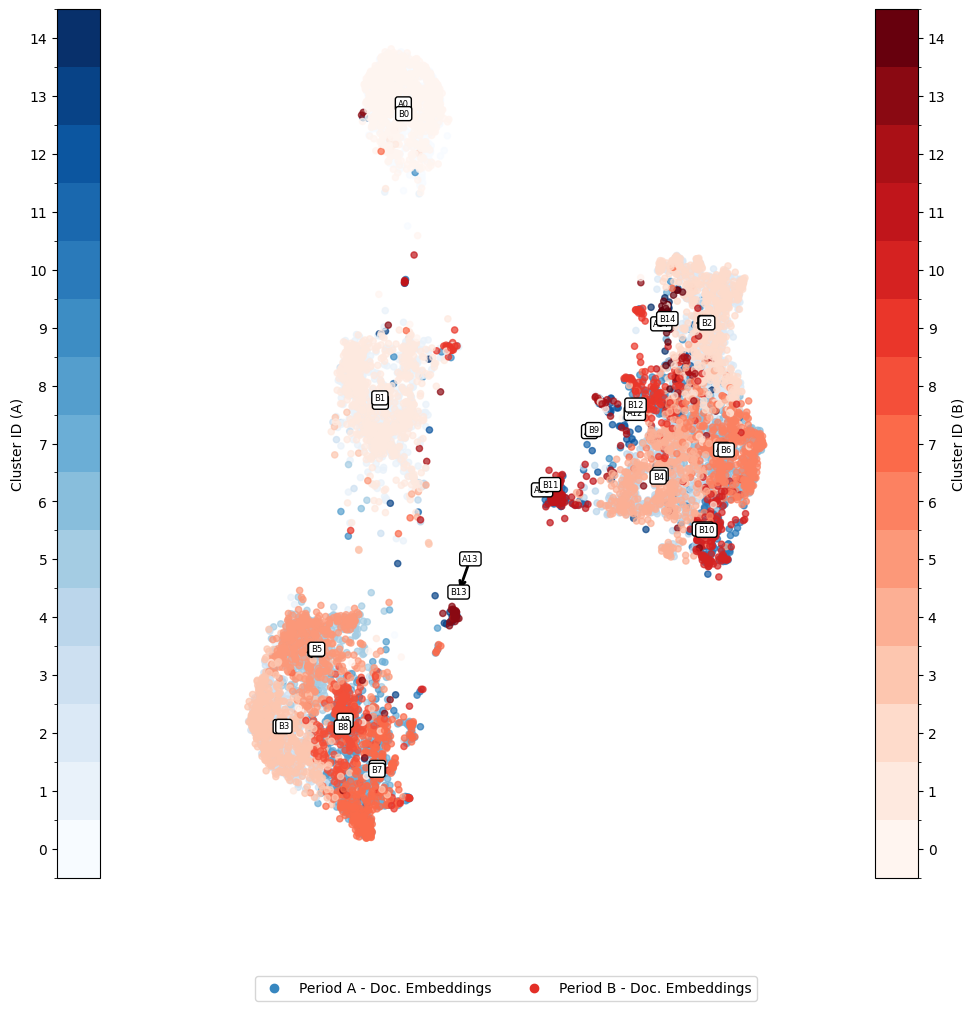

In [21]:
fig, ax = topol_model.vizualize_clusters()
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Drift analysis

In [22]:
no_nan_drifts = { k: v for k, v in topol_model.drifts.items() if isinstance(v, np.ndarray) }
drifts_df = pd.DataFrame.from_dict(no_nan_drifts, orient='index', columns=['x', 'y'])
drifts_df.index.name = "Cluster"

In [23]:
# Normalize drift vectors to unit length
unit_drifts = normalize(drifts_df.dropna().values, norm='l2')

k = 4
# # KMeans on unit vectors ≈ angular k-means (cosine similarity)
# kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
# drifts_df["labels"] = kmeans.fit_predict(unit_drifts)

# Compute angles in radians
angles = np.arctan2(unit_drifts[:, 1], unit_drifts[:, 0])   # range [-pi, pi]
angles = (angles + 2 * np.pi) % (2 * np.pi)                 # convert to [0, 2pi]
sector_size = 2 * np.pi / k                                 # Define number of angular sectors
labels = np.floor(angles / sector_size).astype(int)         # Assign each angle to a sector
drifts_df["labels"] = labels

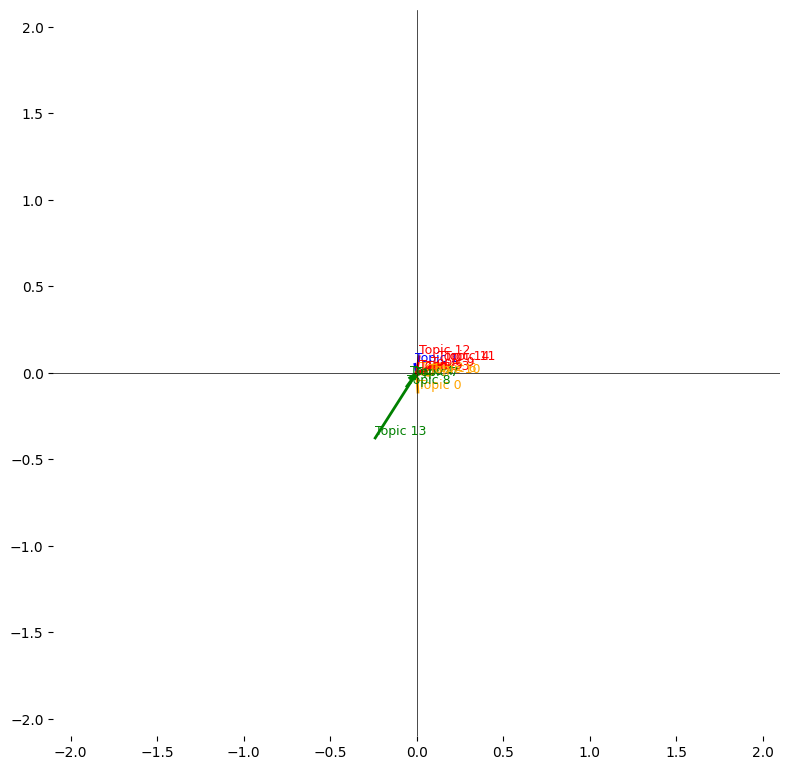

In [24]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray']

fig, ax = plt.subplots(figsize=(8, 10))

for topic_id, row in drifts_df.iterrows():
    x, y, label_id = row['x'], row['y'], int(row['labels'])
    color = colors[label_id]
    ax.plot([0, x], [0, y], color=color, linewidth=2, label=f"Topic {topic_id}")
    ax.text(x, y, f"Topic {topic_id}", fontsize=9, color=color, ha='left', va='bottom')

lim = 2.1
ax.set_aspect('equal', 'box')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
ax.set_frame_on(False)
fig.tight_layout()

fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_drifts.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Drift explainability

In [25]:
fpath = os.path.join(DATA_PATH, "narrative_dimensions.pickle")
if os.path.exists(fpath):
    with open(fpath, "rb") as f:
        NARRATIVE_DIMENSIONS = pickle.load(f)
    print(f"Loaded {len(NARRATIVE_DIMENSIONS)} narrative dimensions from {fpath}")
else:
    raise FileNotFoundError(f"File {fpath} not found. Please generate narrative dimensions first.")
del fpath

Loaded 123 narrative dimensions from /Users/tig1/Programming/TOPOL/data/narrative_dimensions.pickle


In [26]:
fpath = os.path.join(DATA_PATH, "prompt_template.txt")
if os.path.exists(fpath):
    with open(fpath, "r") as f:
        PROMPT_TEMPLATE = f.read()
    print(f"Loaded prompt template from {fpath}")
else:
    raise FileNotFoundError(f"Prompt template file not found at {fpath}")
del fpath

Loaded prompt template from /Users/tig1/Programming/TOPOL/data/prompt_template.txt


In [27]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt = PROMPT_TEMPLATE.replace("#####DIMENSIONS_LIST#####", from_list_to_string(NARRATIVE_DIMENSIONS))
    prompt = prompt.replace("#####TEXT1#####", text1)
    prompt = prompt.replace("#####TEXT2#####", text2)
    return prompt

In [28]:
# chat_completion_func = openai_chat_completion
chat_completion_func = google_chat_completion

In [29]:
zipped_representative_docs = list(zip(
    topol_model.dataset_A.cluster_info['Top_Representative_Docs'],
    topol_model.dataset_B.cluster_info['Top_Representative_Docs']
))
top_n_docs = 3  # Number of top documents to compare per cluster

for i, (top_docs_A, top_docs_B) in tqdm(enumerate(zipped_representative_docs), total=len(zipped_representative_docs)):

    # Get the representative documents for each cluster
    if top_n_docs is not None:
        text1 = from_list_to_string(top_docs_A[:top_n_docs])  # Take top N docs for cluster A
        text2 = from_list_to_string(top_docs_B[:top_n_docs])  # Take top N docs for cluster B
    else:
        text1 = from_list_to_string(top_docs_A)
        text2 = from_list_to_string(top_docs_B)

    # Generate the prompt for the LLM
    prompt = generate_narrative_comparison_prompt(text1, text2)
    response = chat_completion_func(prompt, max_tokens=1000000)

    # Dynamic response variable (you can also use a list or dict instead of naming each one)
    var_name = f"response_row{i}"
    globals()[var_name] = response

    # Parse the JSON response safely
    parsed_llm_out = safe_json_load(response)

    # Save to file
    with open(f"{OUTPUTS_PATH}/{FILES_PREFIX}_ND_row{i}.json", "w", encoding="utf-8") as f:
        json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

    print(f"✅ Processed and saved row {i}")

  0%|          | 0/15 [00:00<?, ?it/s]

Response: ```json
[
  {
    "dimension_title": "Enthusiasm vs. Disappointment",
    "polar_extremes_subtitle": "Disappointment – Enthusiasm",
    "presence": "both",
    "coverage_text1": 60,
    "coverage_text2": 60,
    "difference_confidence": 20,
    "cosine_similarity": 0.3,
    "text1_evidence_sentences": [
      "Just amazing stuff from someone who continues to amaze.",
      "I grabbed this album when it was released in DATE and have never grown tired of it.",
      "Definitely worth a listen."
    ],
    "text2_evidence_sentences": [
      "Sorry folks, I hate to burst everyone's bubble - But this release is just not that good.",
      "I get the feeling some people have not actually taken the time and listened to this entire album before deciding to write some type of disgruntled review, which is ridiculous.",
      "This is an awesome cd"
    ]
  },
  {
    "dimension_title": "Musical Complexity",
    "polar_extremes_subtitle": "Simplicity – Complexity",
    "presence": "bot